In [34]:
import numpy as np
import pandas as pd

In [35]:
file = 'C:\\Users\\reill\\Downloads\\Traffic_Crashes_-_Crashes.csv'
df = pd.DataFrame(pd.read_csv(file))

In [36]:
#Drop high NaN count columns
dropcols = []
for col in df:
    if (df[col].isna().sum() / len(df[col])) > 0.6:
        dropcols.append(col)
df.drop(dropcols, axis='columns', inplace=True)

#Drop unnecessary columns
df.drop(['CRASH_RECORD_ID', 'REPORT_TYPE', 'DATE_POLICE_NOTIFIED', 'LOCATION', 'CRASH_DATE'], axis='columns', inplace=True)
df.replace('UNKNOWN', np.nan, inplace=True)

df = df.dropna(axis='index').reset_index(drop=True)

In [37]:
categorical = ['TRAFFIC_CONTROL_DEVICE',
       'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'MOST_SEVERE_INJURY']
#Removed street name and direction

In [38]:
numerical = ['POSTED_SPEED_LIMIT', 'STREET_NO', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE']

#This leaves out the datetime column

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = df
scaled_df[numerical] = scaler.fit_transform(scaled_df[numerical])
scaled_df.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,...,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
0,0.252263,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,1.0,0.0,0.155627,1.457387,0.062053,0.001778,0.010912
1,0.252263,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,4.0,0.0,-0.572321,-1.586060,0.357042,0.355384,-0.050762
2,0.252263,TRAFFIC SIGNAL,FUNCTIONING IMPROPERLY,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,5.0,0.0,0.0,0.0,1.065562,-0.064337,0.357042,-0.276717,0.067092
3,0.252263,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,0.0,0.883575,-0.064337,0.652031,0.198169,0.014718
4,0.252263,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE OPPOSITE DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,0.0,0.883575,-1.586060,0.062053,0.116960,-0.055930


In [40]:
scaled_df = pd.get_dummies(scaled_df)

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [42]:
mini = scaled_df.sample(60000, axis='index')

x = mini.drop(['INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN'], axis='columns')
y = mini['INJURIES_FATAL']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [43]:
forest_fatal = RandomForestRegressor(n_jobs=16)
forest_fatal.fit(x_train, y_train)

RandomForestRegressor(n_jobs=16)

In [44]:
y_pred = forest_fatal.predict(x_test)

from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9282427321269653

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=300)
pca.fit(x)

PCA(n_components=300)

In [46]:
x = pd.DataFrame(pca.transform(x))

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

forest_fatal = RandomForestRegressor(n_jobs=16)
forest_fatal.fit(x_train, y_train)

y_pred = forest_fatal.predict(x_test)
r2_score(y_test, y_pred)

0.9128038277511963

In [49]:
pd.Series(y_pred).value_counts()

0.00    11977
1.01        4
0.05        3
0.07        2
1.04        2
1.03        1
0.10        1
0.02        1
1.00        1
0.61        1
1.02        1
1.23        1
1.24        1
0.11        1
0.43        1
1.18        1
1.19        1
dtype: int64

## So the model is basically just guessing zero every time and happens to be right in most cases

In [53]:
df['INJURIES_FATAL'].value_counts()

0.0    613782
1.0       667
2.0        43
3.0         7
4.0         1
Name: INJURIES_FATAL, dtype: int64

In [55]:
nonfatal = df[df['INJURIES_FATAL'] == 0.0]
hasfatal = df[df['INJURIES_FATAL'] != 0.0]

In [57]:
from sklearn.utils import resample

nonfatal_down = resample(nonfatal, replace=False, n_samples=1000)

In [58]:
down_df = pd.concat([nonfatal_down, hasfatal])

In [59]:
down_df['INJURIES_FATAL'].value_counts()

0.0    1000
1.0     667
2.0      43
3.0       7
4.0       1
Name: INJURIES_FATAL, dtype: int64

In [60]:
scaler = StandardScaler()
scaled_df = down_df
scaled_df[numerical] = scaler.fit_transform(scaled_df[numerical])
scaled_df.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,...,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
218199,0.169846,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,0.0,0.042999,-0.043665,-0.524715,0.955253,-1.313661
457682,0.169846,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,3.0,0.0,-0.418704,-0.543778,-0.817586,0.564531,0.516312
544704,0.169846,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,0.0,0.350801,-0.543778,-0.231843,1.450888,-1.357192
523850,0.169846,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,WET,NO DEFECTS,...,0.0,0.0,0.0,3.0,0.0,0.196900,0.956560,0.646773,1.009739,-2.201449
191736,1.093250,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,1.0,0.0,0.350801,-0.543778,1.525388,-1.076567,-0.733372


In [61]:
scaled_df = pd.get_dummies(scaled_df)

In [62]:
x = scaled_df.drop(['INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN'], axis='columns')
y = scaled_df['INJURIES_FATAL']

In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=300)
pca.fit(x)
x = pd.DataFrame(pca.transform(x))

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

forest_fatal = RandomForestRegressor(n_jobs=16)
forest_fatal.fit(x_train, y_train)

y_pred = forest_fatal.predict(x_test)
r2_score(y_test, y_pred)

0.6277275025688819

In [72]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor()
cross = GridSearchCV(rf, {'n_estimators':[50, 100, 200, 400, 600],
                          'max_depth':[1, 2, 4]}, scoring='r2', n_jobs=16)
cross.fit(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=16,
             param_grid={'max_depth': [1, 2, 4],
                         'n_estimators': [50, 100, 200, 400, 600]},
             scoring='r2', verbose=2)

In [75]:
cross.best_estimator_

RandomForestRegressor(max_depth=4, n_estimators=600)

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

forest_fatal = RandomForestRegressor(max_depth=4, n_estimators=600, n_jobs=16)
forest_fatal.fit(x_train, y_train)

y_pred = forest_fatal.predict(x_test)
r2_score(y_test, y_pred)

0.6415708503043034

In [77]:
forest_fatal = RandomForestRegressor(max_depth=None, n_estimators=600, n_jobs=16)
forest_fatal.fit(x_train, y_train)

y_pred = forest_fatal.predict(x_test)
r2_score(y_test, y_pred)

0.7023960640073765

<Axes: xlabel='0', ylabel='count'>

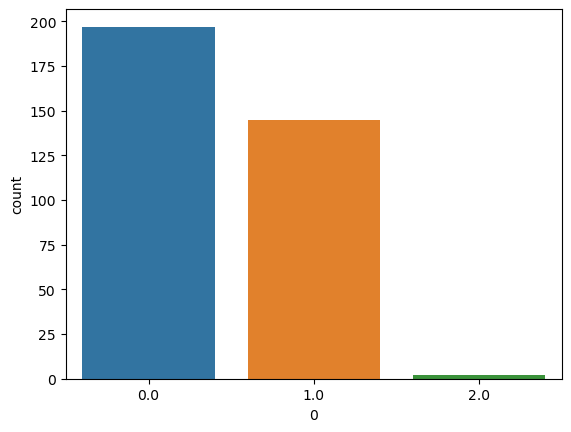

In [88]:
import seaborn as sns
y_pred = pd.DataFrame(y_pred)
sns.countplot(y_pred.round(), x=0)